In [1]:
!pip install kora -q
from kora import drive
drive.link_nbs()

     |████████████████████████████████| 57 kB 768 kB/s 
     |████████████████████████████████| 60 kB 2.4 MB/s 
Mounted at /content/drive


In [2]:
import utils
from google.colab.patches import cv2_imshow

importing Jupyter notebook from /nbs/utils.ipynb
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
#import efficientnet.keras as efn
#from keras.applications.efficientnet import EfficientNetB0
from keras import layers
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, GlobalAveragePooling2D,AveragePooling2D, BatchNormalization, Conv2D, MaxPool2D, Add, Activation, ReLU
from tensorflow import keras
from tensorflow import Tensor
import numpy as np

In [4]:
IMG_SIZE = (224,224)
EPOCHS = 30
BATCH_SIZE = 32
NUM_CLASSES = 4


In [5]:
""" Load TVHI dataset """
#Load the dataset which has already been preprocessed, set needDirectories to False if SF_train, SF_test, and SF_validation dirs already exist
train_ds, test_ds, val_ds, train_labels, test_labels, validation_labels, class_names = utils.loadTVHI(img_size = IMG_SIZE, needDirectories=True)

#Path to pre-trained model
#SF_weights = "/content/drive/MyDrive/model_weights.h5"


--2022-04-20 00:41:52--  http://www.robots.ox.ac.uk/~alonso/data/tv_human_interactions_videos.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~alonso/data/tv_human_interactions_videos.tar.gz [following]
--2022-04-20 00:41:53--  https://www.robots.ox.ac.uk/~alonso/data/tv_human_interactions_videos.tar.gz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 163535078 (156M) [application/x-gzip]
Saving to: ‘tv_human_interactions_videos.tar.gz’

tv_human_interactio 100%[===================>] 155.96M  27.0MB/s    in 6.6s    

2022-04-20 00:42:00 (23.5 MB/s) - ‘tv_human_interactions_videos.tar.gz’ saved [163535078/163535078]

--2022-04-20 00:42:00--  http://www.robots.ox.ac.uk/~alonso/data/readme

In [6]:
""" One-hot encoding """

def onehot_encoding(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

#Apply one hot encoding to the different datasets
train_ds = train_ds.map(onehot_encoding, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(onehot_encoding, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

test_ds = test_ds.map(onehot_encoding)


tf.Tensor([0. 1. 0. 0.], shape=(4,), dtype=float32)
indexis:  [1]
(32, 224, 224, 3)
highFive


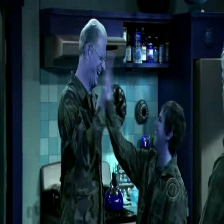

tf.Tensor([0. 0. 1. 0.], shape=(4,), dtype=float32)
indexis:  [2]
(32, 224, 224, 3)
hug


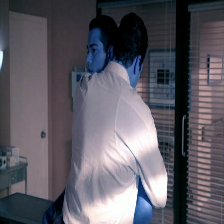

In [7]:
import matplotlib.pyplot as plt


for images, labels in train_ds.take(2):
  print(labels[0])
  index=[i for i, e in enumerate(labels[0]) if e == 1]
  print("indexis: ",index)
  print(images.shape)
  print(class_names[index[0]])
  cv2_imshow(images[0].numpy().astype("uint8"))

In [8]:
def relu_bn(inputs: Tensor) -> Tensor:
    relu = tf.nn.relu(inputs)
    bn = BatchNormalization()(relu)
    return bn

In [9]:
def residual_block(x: Tensor, downsample: bool, filters: int, kernel_size: int = 3) -> Tensor:
    y = Conv2D(kernel_size=kernel_size,
               strides= (1 if not downsample else 2),
               filters=filters,
               padding="same")(x)
    y = relu_bn(y)
    y = Conv2D(kernel_size=kernel_size,
               strides=1,
               filters=filters,
               padding="same")(y)

    if downsample:
        x = Conv2D(kernel_size=1,
                   strides=2,
                   filters=filters,
                   padding="same")(x)
    out = Add()([x, y])
    out = relu_bn(out)
    return out

In [10]:
def create_res_net():   #Resnet20
    
    inputs = Input(shape=(224, 224, 3))
    num_filters = 16
    
    data_augmentation = Sequential([
        layers.Rescaling(scale=1./255),
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(mode="horizontal"),
        layers.RandomContrast(factor=0.7),
        layers.RandomZoom(0.1)
    ],
    name="img_augmentation",)

    t = data_augmentation(inputs)

    t = BatchNormalization()(t)
    t = Conv2D(kernel_size=3,
               strides=1,
               filters=num_filters,
               padding="same")(t)
    t = relu_bn(t)
    
    num_blocks_list = [1, 1, 1, 1]
    for i in range(len(num_blocks_list)):
        num_blocks = num_blocks_list[i]
        for j in range(num_blocks):
            t = residual_block(t, downsample=(j==0 and i!=0), filters=num_filters)
        num_filters *= 2
    
    t = AveragePooling2D(2)(t)
    t = Flatten()(t)
    outputs = Dense(40, activation='softmax')(t)
    
    model = Model(inputs, outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [11]:
import keras
""" Build transfer learning model """

def build_tfl_model(num_classes):

    # b_model = tf.keras.Sequential([
    # # Add the preprocessing layers you created earlier.
    #   #keras.Input(shape=(224, 224, 3)),
    #   data_augmentation,
    #   ResNet18(40) #
    # # Rest of your model.
    # ])

    b_model=create_res_net()
 
    #b_model.build(input_shape = (None,224,224,3))
    
    #Load old model and set the weights from there
    old_model = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/ResNet20_1")
    b_model.set_weights(old_model.get_weights())

    # Freeze pretrained weights so no more training will happen
    b_model.trainable = False
    print("HERE")
    inputs = b_model.input
    print("DOUBLEHERE")
    b_output =  b_model.layers[-3].output
    #print(b_output)
    print("TripleHERE")

    # tvhi_output = layers.Dense(16)(b_output)
    # outputs = layers.Dense(4, activation='softmax')(tvhi_output)
    
    # Add new top layers that will be trained
    x = GlobalAveragePooling2D(name="avg_pool")(b_output)
    x = BatchNormalization()(x)
    
  
    #Set dropout rate to 0.2 to adjust for overfitting as transfer learning is prone to overfitting
    # dropout_rate = 0.2
    # x = Dropout(dropout_rate, name="top_dropout")(x)
    x = layers.Dense(16)(x)
    outputs = Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

    tvhi_model = keras.Model(inputs,outputs)

    #tvhi_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    #default learningrate of Adam is 0.001 so should be 1e-4 (1/10 * 0.001)
    #tf_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    tvhi_model.compile(
        optimizer='adam', loss="categorical_crossentropy", metrics=["accuracy"]
    )

    return tvhi_model


In [12]:
""" Train the model """
#Build the model
model = build_tfl_model(num_classes=NUM_CLASSES)
model.summary()

#Fit the model 
#history = model.fit(train_ds, epochs=50, validation_data=val_ds, verbose=2)

#Save weights and model as we need these for transfer learning 
#model.save_weights("TFL_weights.h5")
#model.save("TFL_model")


HERE
DOUBLEHERE
TripleHERE
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 img_augmentation (Sequential)  (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 224, 224, 3)  12         ['img_augmentation[0][0]']       
 alization)                                                                                       
                                                                 

In [13]:
# from keras.callbacks import ModelCheckpoint, EarlyStopping
# checkpoint = ModelCheckpoint("TFL_Model_1", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1, save_format="tf")
# early = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, mode='auto')


In [14]:
history=model.fit(train_ds, epochs=20, validation_data=val_ds, verbose=1)

Epoch 1/20
3/3 [==============================] - 15s 1s/step - loss: 1.6733 - accuracy: 0.2471 - val_loss: 1.3818 - val_accuracy: 0.2667
Epoch 2/20
3/3 [==============================] - 1s 156ms/step - loss: 1.5762 - accuracy: 0.3059 - val_loss: 1.3819 - val_accuracy: 0.2667
Epoch 3/20
3/3 [==============================] - 1s 160ms/step - loss: 1.5266 - accuracy: 0.3176 - val_loss: 1.3822 - val_accuracy: 0.2667
Epoch 4/20
3/3 [==============================] - 1s 155ms/step - loss: 1.4890 - accuracy: 0.3059 - val_loss: 1.3827 - val_accuracy: 0.2667
Epoch 5/20
3/3 [==============================] - 1s 159ms/step - loss: 1.4348 - accuracy: 0.2706 - val_loss: 1.3826 - val_accuracy: 0.2667
Epoch 6/20
3/3 [==============================] - 1s 155ms/step - loss: 1.4494 - accuracy: 0.3294 - val_loss: 1.3828 - val_accuracy: 0.2000
Epoch 7/20
3/3 [==============================] - 1s 155ms/step - loss: 1.3291 - accuracy: 0.3294 - val_loss: 1.3826 - val_accuracy: 0.2000
Epoch 8/20
3/3 [======

In [15]:
#Printing the val & training loss and accuracy for baseline model 
print(f"Baseline model training accuracy: {history.history['accuracy'][-1]} and validation accuracy: {history.history['val_accuracy'][-1]}")
print(f"Baseline model training loss: {history.history['loss'][-1]} and validation loss: {history.history['val_loss'][-1]}")

Baseline model training accuracy: 0.4470588266849518 and validation accuracy: 0.2666666805744171
Baseline model training loss: 1.2537778615951538 and validation loss: 1.3831920623779297


In [17]:
model.save('/content/drive/MyDrive/Colab Notebooks/TFLModel_1')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/TFLModel_1/assets


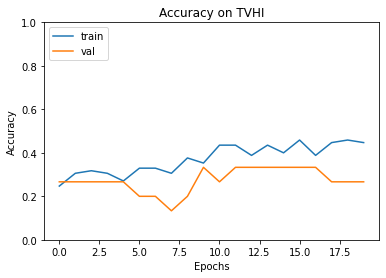

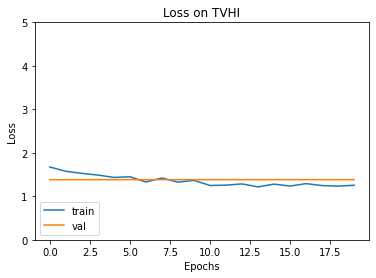

In [16]:
#Plot loss and accuracy before finetuning
utils.plotAccuracy("Accuracy on TVHI", history.history['accuracy'], history.history['val_accuracy'])                   
utils.plotLoss("Loss on TVHI", history.history['loss'], history.history['val_loss'])

In [18]:
## Evaluation

ModelLoss, ModelAccuracy = model.evaluate(test_ds)

print('Model Loss is {}'.format(ModelLoss))
print('Model Accuracy is {}'.format(ModelAccuracy))

4/4 [==============================] - 1s 209ms/step - loss: 1.3887 - accuracy: 0.2400
Model Loss is 1.3887417316436768
Model Accuracy is 0.23999999463558197


Epoch 1/10
3/3 - 7s - loss: 1.1468 - accuracy: 0.4941 - val_loss: 1.3834 - val_accuracy: 0.2667 - 7s/epoch - 2s/step
Epoch 2/10
3/3 - 1s - loss: 1.1816 - accuracy: 0.4471 - val_loss: 1.3825 - val_accuracy: 0.2000 - 1s/epoch - 421ms/step
Epoch 3/10
3/3 - 1s - loss: 1.1851 - accuracy: 0.4471 - val_loss: 1.3816 - val_accuracy: 0.1333 - 1s/epoch - 418ms/step
Epoch 4/10
3/3 - 1s - loss: 1.2236 - accuracy: 0.4000 - val_loss: 1.3813 - val_accuracy: 0.1333 - 1s/epoch - 427ms/step
Epoch 5/10
3/3 - 1s - loss: 1.1722 - accuracy: 0.4706 - val_loss: 1.3809 - val_accuracy: 0.1333 - 1s/epoch - 418ms/step
Epoch 6/10
3/3 - 1s - loss: 1.1728 - accuracy: 0.4471 - val_loss: 1.3807 - val_accuracy: 0.1333 - 1s/epoch - 419ms/step
Epoch 7/10
3/3 - 1s - loss: 1.1529 - accuracy: 0.4706 - val_loss: 1.3811 - val_accuracy: 0.1333 - 1s/epoch - 420ms/step
Epoch 8/10
3/3 - 1s - loss: 1.1272 - accuracy: 0.4706 - val_loss: 1.3813 - val_accuracy: 0.2000 - 1s/epoch - 419ms/step
Epoch 9/10
3/3 - 1s - loss: 1.1311 - accura

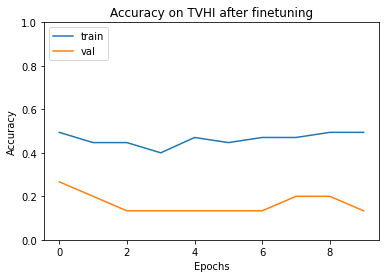

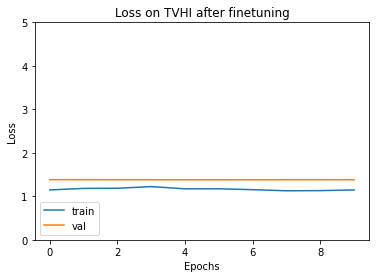

In [19]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-50:]:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )


unfreeze_model(model)

epochs = 10
history2 = model.fit(train_ds, epochs=epochs, validation_data=val_ds, verbose=2)

utils.plotAccuracy("Accuracy on TVHI after finetuning", history2.history['accuracy'], history2.history['val_accuracy'])
utils.plotLoss("Loss on TVHI after finetuning", history2.history['loss'], history2.history['val_loss'])


In [22]:
#Printing the val & training loss and accuracy for baseline model 
print(f"Baseline model training accuracy: {history2.history['accuracy'][-1]} and validation accuracy: {history2.history['val_accuracy'][-1]}")
print(f"Baseline model training loss: {history2.history['loss'][-1]} and validation loss: {history2.history['val_loss'][-1]}")

Baseline model training accuracy: 0.4941176474094391 and validation accuracy: 0.13333334028720856
Baseline model training loss: 1.1469054222106934 and validation loss: 1.3811991214752197


In [20]:
## Evaluation

ModelLoss, ModelAccuracy = model.evaluate(test_ds)

print('Model Loss is {}'.format(ModelLoss))
print('Model Accuracy is {}'.format(ModelAccuracy))

4/4 [==============================] - 1s 87ms/step - loss: 1.3849 - accuracy: 0.2800
Model Loss is 1.3848587274551392
Model Accuracy is 0.2800000011920929
